# Pulse Simulation

## Setup

In [1]:
%load_ext autoreload
%autoreload 1

%aimport visualization
%aimport transmon
%aimport pulses

import visualization as viz
import pulses as ps
from transmon import Transmon

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt

import datetime as dt
import os

if 'berkeley' in plt.style.available:
    plt.style.use('berkeley')

# Single Transmon N-Level System

We'll start with a not-so-short explanation of the semiclassical model of a transmon coupled to a microwave drive field. Feel free to skip this.

The Hamiltonian for a single transmon coupled to an electric field can be written as

$$H(t) = H_\mathrm{sys}(t) + H_\mathrm{drive}(t)$$

where $H_\mathrm{sys}(t)$ is the Hamiltonian for the system and $H_\mathrm{drive}(t)$ describes a semiclassical coupling to an electromagnetic field. The system Hamiltonian in it's most general form is given by

$$H_\mathrm{sys}(t) = \sum_n\omega_n(t) |n\rangle\langle n|$$

but for a fixed frequency transmon we can set $\omega_n$ to be time independent. (We will use the notation $\omega_{nm} = \omega_{n} - \omega_{m}$). Some people like to use the Duffing approximation [1], in which they write 

$$H_\mathrm{sys}(t) = \omega_{01} a^\dagger a + \frac{\alpha}{2}a^\dagger a^\dagger a a$$

where $\omega_{01}$ is the qubit frequency and $\alpha = \omega_{12} - \omega_{01}$ is the qubit anharmonicity. But if you're doing numerical simulation, you might as well use the true transmon energies.

## Drive Hamiltonian

Generally, the field applied to a transmon via a control line is coupled to the transmon mode capacitively, so this coupling can be described by the hamiltonian

$$H_\mathrm{drive}(t) = \frac{1}{2}\left(\gamma(t) + \gamma^*(t)\right) i (a - a^\dagger)$$

where $\gamma(t)$ is the amplitude of the field, written in complex notation. We note that if our qubit is inductively coupled to the field, this would take the form $a + a^\dagger$

Generally we think of $\gamma(t)$ as consisting of a carrier that gets mixed with a pulse envelope. Thus, we can write

$$\gamma(t) = \Omega(t) e^{i(\omega_d t +\phi)}$$

where $\Omega(t) = I(t) + iQ(t)$ is the pulse envelope which is often written in terms of the in phase ($I$) and quadrature ($Q$) components. Thus we can write the total drive Hamiltonian as

$$H_\mathrm{drive}(t) = \frac{1}{2}\left(\Omega(t)e^{i(\omega_d t + \phi)} + \Omega^*(t) e^{-i(\omega_d t + \phi)}\right) i (a - a^\dagger)$$

In the following analysis we will just absorb $\phi$ into our definition of $\Omega(t)$

## Rotating Frames and the RWA

We can move into the frame of the drive (the "rotating frame") by applying a unitary transformation given by

$$U = \exp{i\omega_d t a^\dagger a} = \sum_n e^{in\omega_d t} |n\rangle \langle n|$$

The drive hamiltonian in the rotating frame [2] is then given by 

$$\widetilde{H}_\mathrm{drive} = U H_\mathrm{drive} U^\dagger + i\dot{U}U^\dagger$$

Since $a$ and $a^\dagger$ the only operators in $H_\mathrm{drive}$, we can simply compute

$$U a U^\dagger \rightarrow e^{i\omega_d t} \qquad Ua^\dagger U^\dagger \rightarrow e^{-i\omega_d t}$$

You may convince yourself that this is true by writing $a$ as $a = \sqrt{n}|n-1\rangle\langle n|$. Now after applying this transformation, the drive Hamiltonian becomes

$$\widetilde{H}_\mathrm{drive} = -\omega_d a^\dagger a + \frac{1}{2} i \left(\Omega(t) a - \Omega^*(t) a^\dagger  - \Omega(t) a^\dagger e^{2i\omega_d t} + \Omega^*(t) a e^{-2i\omega_d t} \right)$$

The rotating wave approximation (RWA) states that since the last two terms are oscillating at a frequency $2\omega_d$, the contribution to the dynamics from these terms will average out on the timescale of interest. To understand when the RWA is able to applied, you should compare $\Omega(t)$ and $2\omega_d$, since $\max\{\Omega(t)\}$ dictates the timescale of the dynamics of interest and $2\omega_d$ dictates the timescale on which the fast oscillations become relevant. (In most cases when analyzing single qubit dynamics, $\max\{\Omega(t)/2\pi\} < 100$ MHz and $2\omega_d/2\pi \sim 5$ GHz so this is valid). See [3] for a discussion on when the RWA is valid.

After dropping the fast oscillating terms (making the RWA), the drive hamiltonian looks like

$$\widetilde{H}_\mathrm{drive} = -\omega_d a^\dagger a + \frac{1}{2}i \left(\Omega(t) a - \Omega^*(t) a^\dagger\right)$$

which is the canonical hamiltonian you'll often see. This can also be written in terms of $I$ and $Q$ by taking $\Omega(t) = I(t) + iQ(t)$

$$\widetilde{H}_\mathrm{drive} = -\omega_d a^\dagger a + \frac{1}{2}\left(I(t) (a - a^\dagger)+ iQ(t)(a + a^\dagger)\right)$$

Finally, if we choose to remain in the lab frame, we can still make the RWA by droppping the appropriate terms after which

$$H_\mathrm{drive} \rightarrow \frac{1}{2}i\left(\Omega(t) a e^{i\omega_d t} + \Omega^* (t) a^\dagger e^{-i\omega_d t}\right)$$

### A small aside

We note that the $i = e^i\pi/2$ out front is simply a global phase, which we can always absorb into our definition of $\Omega(t)$. If we do this, we see that the drive Hamiltonian becomes

\begin{align}
\widetilde{H}_\mathrm{drive} 
&= -\omega_d a^\dagger a + \frac{1}{2}\left(a \Omega(t) + a^\dagger \Omega^*(t)\right) \\
&= -\omega_d a^\dagger a + \frac{1}{2}\left(I(t) (a + a^\dagger) + iQ(t) (a-a^\dagger) \right) \\
&\rightarrow -\omega_d (I - \sigma_z)/2 + \frac{1}{2}\left( I(t) \sigma_x + iQ(t) \sigma_y\right)
\end{align}

where in the last step we take the 2 level approximation. This is why you'll often see people describe $I$ and $Q$ as driving the $X$ and $Y$ quadratures of the qubit, but it is worth remembering that this is only true under the RWA. 

In order to engineer the RWA hamiltonian exactly, you would need to couple to supplement the capacitively coupled driving field with an inductively coupled driving field that is 90 degrees out of phase. This is similar to driving a spin system with circularly polarized light. See [4].

## Combining the System and Drive Hamiltonians

If we combine the system and drive hamiltonians, we see that in the frame of the drive, we have

$$H(t) = \Sigma_n \omega_n |n\rangle\langle n| -\omega_d a^\dagger a + \frac{1}{2}i\left(\Omega(t) a - \Omega^*(t)a^\dagger\right)$$

Normally, if when doing a single qubit gate we'll have $\omega_d = \omega_{01}$. But since $\omega_n \neq n\omega_{01}$ for a transmon, we'll be left with a drift hamiltonian, defined as 
$$H_\mathrm{drift} = H_\mathrm{system} - \omega_d a^\dagger a$$

The total hamiltonian in the frame of the drive is now given by (under the RWA)
$$H(t) = H_\mathrm{drift} + \frac{1}{2}\left(\Omega(t) a + \Omega^*(t) a^\dagger \right)$$

This can also be written in the lab frame (under the RWA) as
$$H(t) = H_\mathrm{system} + \frac{1}{2}\left(\Omega(t) a e^{i\omega_d t} + a^\dagger e^{-i\omega_d t}\right)$$

Finally, we may wish to not make the rotating wave approximation, in which case our lab frame hamiltonian is
$$H(t) = H_\mathrm{system} + \frac{1}{2}\left(\Omega(t) e^{i\omega_d t} + a^\dagger e^{-i\omega_d t}\right)(a + a^\dagger)$$

[1] https://arxiv.org/abs/1904.06560

[2] https://en.wikipedia.org/wiki/Unitary_transformation_(quantum_mechanics)

[3] https://berkeleyqnl.slack.com/archives/CL2NFJDC4/p1588306894337700

[4] https://journals.aps.org/pra/abstract/10.1103/PhysRevA.90.012302

# Setting up the System and Drive Hamiltonian

I (Larry) generally prefer to simulate in the lab frame and apply a rotation to the observables afterwards to see what happens in the qubit frames. This makes it easier to switch between applying RWA or keeping the counterrotating terms. One thing to note, populations are not affected by the choice of frame, only the phases.

## Defining the System Parameters
This cell sets the 

In [3]:
# These are accurate to about 0.1%, used for higher levels
Ec = 0.224195631112105 # GHz 
Ej = 19.54125919320958 # GHz

# These are experimental frequencies, used for |1> and |2>
f01 = 5686533478.944176
f12 = 5439285951.935773

N = 5
tmon = Transmon(Ec=Ec, Ej=Ej)
print('f01', tmon.omega/(2*np.pi))
print('f12', (tmon.omega + tmon.alpha)/(2*np.pi))

a_op = qt.destroy(N)
n_op = np.array(tmon.eigenbasis(N))

n_op[1,1] = 2*np.pi*f01/1e9
if N > 2:
    n_op[2,2] = 2*np.pi*(f01+f12)/1e9
n_op = qt.Qobj(n_op, dims=[[N],[N]])/(f01*2*np.pi/1e9)

H0 = f01*n_op

f01 5.685984524559105
f12 5.43808037499311


## Defining the AWG Parameters and a Pulse

In [4]:
sampling_rate = 2.5e9
pulse_duration = 40.0e-9

sample_ts = np.arange(sampling_rate*pulse_duration)/sampling_rate
cosine_pulse = ps.cosine_ramp(pulse_duration*sampling_rate, 8.449e6, 10e-9*sampling_rate)

(-300000000.0, 300000000.0)

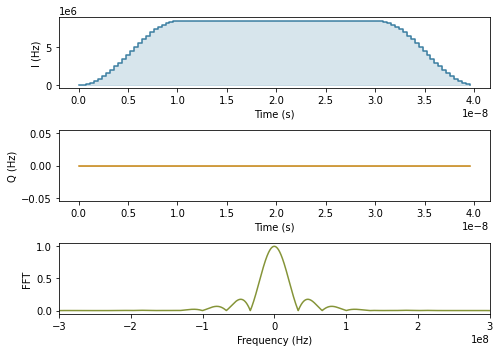

In [5]:
fig, axes = viz.plot_pulse(sample_ts, cosine_pulse)
axes[-1].set_xlim(-0.3e9, 0.3e9)

You can then upconvert the pulse by mixing it with a carrier frequency. Generall you want to address the frequency of the transition with the carrier frequency.

In [6]:
ts, drive = ps.upconvert(cosine_pulse, f01, sampling_rate=sampling_rate, time_steps_per_sample=500)

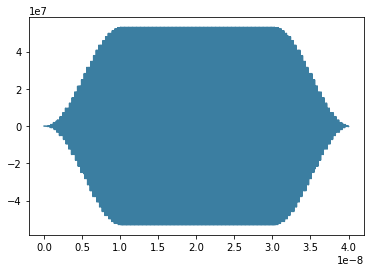

In [7]:
fig, ax = plt.subplots()
ax.plot(ts, np.real(drive))

(1e-06, 5)

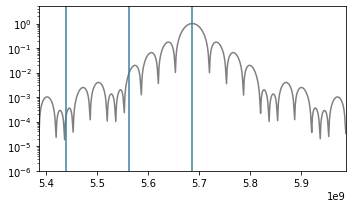

In [8]:
fig, ax = viz.plot_fft(ts, drive, flist=[f01, f12, (f01 + f12)/2])
ax.set_xlim(f01 - 0.3e9, f01 + 0.3e9)
ax.set_ylim(1e-6, 5)

## Saving and Importing Pulses

The easiest way to save a pulse is by using the `numpy.savetxt` and `numpy.loadtxt` functions.

In [ ]:
np.savetxt('cosine_pulse.tsv', cosine_pulse)

In [118]:
# If you try to load a tsv of complex numbers directly, this will throw an error. IDK why
qctrl_pulse2 = np.loadtxt('2020-06-01T13-06-51_X90.tsv', dtype=str).astype('complex')

# Simulating Pulses

In [9]:
def create_system(tlist, drive, H0, rwa=True):
    H = [[H0, np.ones_like(tlist)]]
    N = H0.shape[0]
    
    if rwa:
        H += [[qt.destroy(N), 0.5*drive], [qt.create(N), 0.5*np.conj(drive)]]
    else:
        H += [[(qt.destroy(N) + qt.create(N)), np.real(drive)]]
        
    return H

def qutip_simulate(tlist, drive, H0, psi0, e_ops, rwa=True, T1=None, T2=None):    
    N = H0.shape[0]
    H = create_system(tlist, drive, H0, rwa=rwa)
    
    c_ops = []
    
    if T2 is not None:
        gamma2 = 1/T2
        c_ops += [np.sqrt(gamma2)*n_op]
    if T1 is not None:
        gamma1 = 1/T1
        c_ops += [np.sqrt(gamma1)*qt.destroy(N)]
    
    return qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=e_ops)

def qutip_propagate(tlist, drive, H0, rwa=True, T1=None, T2=None):
    N = H0.shape[0]
    
    c_ops = []
    
    H = create_system(tlist, drive, H0, rwa=rwa)
    
    return qt.propagator(H, tlist, c_ops=c_ops)

def expand_operator_dim(op, N):
    d = op.shape[0]
    new_op = np.diag([1]*N).astype('complex')
    new_op[:d, :d] = op

    return qt.Qobj(new_op)

In [10]:
psis = [qt.basis(N, i) for i in range(N)]
N_ops = [psi*psi.dag() for psi in psis]
P_ops = [expand_operator_dim(p, N) for p in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]]

## Population

In [11]:
ts, drive = ps.upconvert(cosine_pulse, f01, sampling_rate=sampling_rate, time_steps_per_sample=500)
populations = qutip_simulate(ts, drive, 2*np.pi*H0, psis[0], N_ops, rwa=True).expect

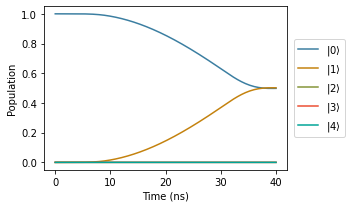

In [12]:
fig, ax = viz.plot_populations(ts/1e-9, populations, figsize=(5, 3))

## Pauli Operators

In [13]:
ts, drive = ps.upconvert(cosine_pulse, f01, sampling_rate=sampling_rate, time_steps_per_sample=500)
xyz = qutip_simulate(ts, drive, 2*np.pi*H0, psis[0], P_ops, rwa=True).expect

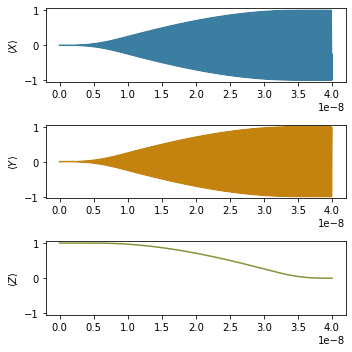

In [14]:
fig, ax = viz.plot_paulis(ts, *xyz)

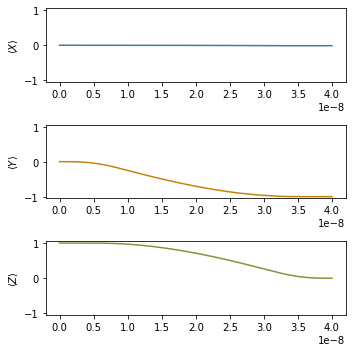

In [15]:
fig, ax = viz.plot_paulis(ts, *xyz, omega=2*np.pi*f01)

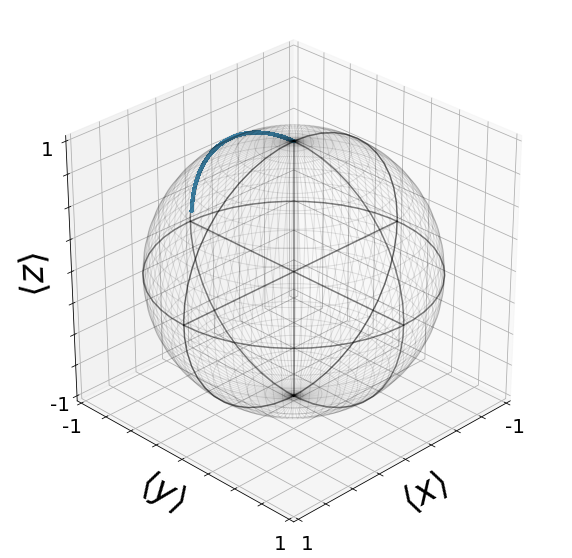

In [71]:
b = viz.plot_bloch(ts, *xyz, omega=2*np.pi*f01, point_size=5, show_background=True)

# Gates

In [285]:
def pauli_distance(x, y, z, target_x, target_y, target_z):
    return np.sqrt((x - target_x)**2 + (y - target_y)**2 + (z - target_z)**2) 

def trace_distance(U, U_target):
    return np.abs(np.trace(np.conj(U.T)@U_target))

def rotate_propagator(U, U_rotation):
    return np.conj(U_rotation.T)@U

def projection_operator(N, m):
    return qt.Qobj(np.diag([1]*m + [0]*(N-m)))